In [1]:
import pickle
from pathlib import Path
import glob2
import numpy as np
import torch
import transformers
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# loading data

data_path = '../data/interim'

dementia_pickles = [ Path(p).absolute() for p in glob2.glob(data_path + '/dementia/pitt/cookie/*') ]
control_pickles = [ Path(p).absolute() for p in glob2.glob(data_path + '/control/pitt/cookie/*') ]

def unpickle_all_files(aList):
    result = {}
    for aPath in aList:
        with open(str(aPath), 'rb') as handle:
            b = pickle.load(handle)
        result[aPath.stem] = b
    return result

dementia_data = unpickle_all_files(dementia_pickles)
control_data = unpickle_all_files(control_pickles)

dementia_texts = {k:v['text'] for k,v in dementia_data.items()}
control_texts = {k:v['text'] for k,v in control_data.items()}

In [8]:
dementia_texts['120-4']

" Tell me everything you see happening there, everything that's going on in that picture. Okay, well the little boy is stealing some cookies, taking some cookies when his mother's not looking and he's going to fall off the stool because it's tipping over and the little girl is saying, she reaches up for a cookie and pretty soon it's not going to be very quiet. The mother is wiping the dishes as the sink is overflowing on the floor and she's walking in the water and apparently unconcerned. And the window is open. As far as things happening, I guess that's about it. She's wiping the dishes."

In [3]:
# see examples
print('Example of DEMENTIA transcription:')
dementia_sample = list(dementia_texts.values())[np.random.randint(len(dementia_texts.values()))]
print(dementia_sample)
print('\nExample of CONTROL transcription:')
control_sample = list(control_texts.values())[np.random.randint(len(control_texts.values()))]
print(control_sample)

Example of DEMENTIA transcription:
 I want you to take a look at that picture. Oh boy. I want you to tell me everything you see happening there. Everything that's going on. The kids are trying to get the cookies. And she's laughing but holding her hand up to them. And they know he's going to fall off the chair. And their mother is doing the dishes. And not being careful she didn't turn the water off. And the water is all going to the floor. Instead of getting the dishes all dry. That's all. I can tuck two cups in a plate. That's it. Thanks.

Example of CONTROL transcription:
 I'm going to show you a picture. And in the picture, there's some things going on. I want you to do is just look at the picture and describe to me any action you see taking place or anything you see happening. The kids are swiping some cookies there, and the stool is upsetting. And the kid, the girl's telling her to be quiet. So his mother over there washing dishes, and the sink's overflowing. And the window's up.

In [4]:
from transformers import DistilBertTokenizer, DistilBertModel

In [5]:
final_transcript = '[CLS]' + ' [SEP]'.join([a['text'] for a in dementia_data['078-0']['segments']]) + ' [SEP]'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
inputs = tokenizer(final_transcript, return_tensors="pt", truncation=True, max_length=500, padding='max_length')
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [8]:
last_hidden_states.shape

torch.Size([1, 500, 768])

In [9]:
last_hidden_states[0]

tensor([[-0.0844,  0.0845,  0.1268,  ..., -0.0295,  0.3428,  0.3118],
        [-0.0476,  0.1092,  0.1339,  ..., -0.0294,  0.3267,  0.3059],
        [ 0.4353, -0.0547,  0.3989,  ...,  0.4625,  0.7648,  0.7710],
        ...,
        [ 0.2075,  0.0735,  0.0068,  ...,  0.1290,  0.0050, -0.2418],
        [ 0.0626, -0.0365, -0.0858,  ...,  0.2477, -0.0697, -0.0681],
        [ 0.0350,  0.0222, -0.0436,  ...,  0.2180, -0.0666,  0.0080]],
       grad_fn=<SelectBackward0>)

In [54]:
inputs['input_ids'].shape

torch.Size([1, 500])

In [55]:
last_hidden_states.shape

torch.Size([1, 500, 768])

In [58]:
last_hidden_states.detach().numpy()

array([[[-0.08441833,  0.08449329,  0.12680854, ..., -0.02945847,
          0.34278136,  0.3118286 ],
        [-0.04758149,  0.10920547,  0.13391875, ..., -0.029373  ,
          0.3267451 ,  0.3059093 ],
        [ 0.43527514, -0.05470229,  0.39889002, ...,  0.46251014,
          0.7648194 ,  0.7710148 ],
        ...,
        [ 0.20745543,  0.07352588,  0.00680953, ...,  0.1289518 ,
          0.0049639 , -0.24180306],
        [ 0.06263701, -0.03647479, -0.08579326, ...,  0.24769208,
         -0.06973306, -0.06805833],
        [ 0.03499333,  0.02217047, -0.04363602, ...,  0.21797748,
         -0.06661072,  0.00801057]]], dtype=float32)

In [43]:
train_ratio, valid_ratio, test_ratio = 0.6, 0.2, 0.2
X = list(control_texts.values())+list(dementia_texts.values())
y = [0]*len(control_texts.values())+[1]*len(dementia_texts.values())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_ratio, random_state=42)

## Text Classification with BERT & Pytorch
Reference: https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch

In [31]:
from transformers import BertModel, BertTokenizer

In [29]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


501


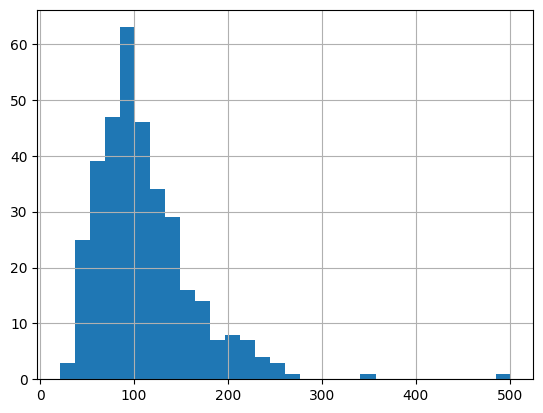

In [44]:
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [46]:
# tokenize and encode sequences in the training set
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    X_train,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_valid,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/zhome/c1/d/164546/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [47]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train)
print("train_y:",train_y)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_valid)
print("val_y:",val_y)

train_y: tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1,

In [48]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [49]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [54]:
from torch import nn

class BERT_Arch(nn.Module):
    def __init__(self, bert,output_size):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,output_size)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)
        return x

In [55]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert,2)

# push the model to GPU
device='cpu'
model = model.to(device)

In [56]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/zhome/c1/d/164546/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [60]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

print(class_wts)

[1.11538462 0.90625   ]


In [61]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 30

In [ ]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
    total_labels =[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1